This script is for calculating the specific surface area ($S_{BET}$) of a solid sample, including error from Inverse Gas Chromatography measurements, specifically those done on the SEA (Surface energy analyser). Measured parameters are imported from a csv file and the specific surface area of the sample is printed at the end of the document along with visualisations of the adsorption isotherm and BET plot.

In [1]:
import pandas as pd
import numpy as np
from pandas import Series,DataFrame
from scipy import stats, constants
import matplotlib.pyplot as plt
%matplotlib inline

# Organising data

In [2]:
# Reads csv input file and skips rows to where data start
input_file = raw_input('Copy path to input file here \nmake sure to insert extra "\\" and remove "" \n')
df = pd.read_csv(input_file, skiprows = 17,encoding= 'utf-16',delimiter='\t')

Copy path to input file here 
make sure to insert extra "\" and remove "" 
C:\\Users\\tcd\\Desktop\\isotherm_BET_example.csv


In [3]:
# Removing of solvents that arent used in calculation
df= df[(df.Solvent != 'n/a') & (df.Solvent != 'Methane')]

In [4]:
# Renaming columns with funny character
#df.rename(columns ={"Peak Max (Signal) [u'\xb5'V]": 'peak_max_signal'},inplace=True)
df.rename(columns={df.columns[10] :'peak_area',df.columns[11]: 'peak_max_signal'},inplace=True)

# Removing unwanted rows
df = df[df.peak_area != 0]

#  James-Martin pressure correction, j

$$j=\frac{3}{2}\frac{(\frac{p_{in}}{p_{out}})^{2}-1}{(\frac{p_{in}}{p_{out}})^{3}-1}$$

In [5]:
# Atmospheric pressure in torr
p_out = 760

# input pressure is pressure drop + atomospheric pressure
p_in = df['Column Pressure Drop [Torr]'] + p_out

j = (1.5*(((p_in/p_out)**2 -1)/((p_in/p_out)**3 -1)))

# Net Retention Volume, Vn ($\frac{mL}{g}$)

$$V_{N}=\frac{j}{m}F(t_{r}-t_{0})(\frac{T}{273.15})$$

In [6]:
# Creating input for sample mass and change its units
m_df = pd.read_csv(input_file,nrows=1,header=None,skiprows=4,encoding='utf-16',delimiter='\t')
m=float(m_df.ix[:,1:1].values.flatten())
m = m / 1000 # mg to g
vn = (j * df['Exit Flow Rate [sccm]'] * df['Net Ret Time (Max) [min]'] * df['Column Temperature [Kelvin]'] ) / (m * 273.15)

# Partial pressure, p (Pa)

$$p=\frac{n_{i}RH_{peak}273.15}{FA_{peak}}$$

In [7]:
A_peak = df['peak_area']
n_i = df['Amount  [mMol]']
H_peak = df['peak_max_signal']
F = df['Exit Flow Rate [sccm]']

In [8]:
# Converting units to SI

vn_SI = vn * 0.001 # converts mg/L to m^3/kg
A_peak = A_peak * 6E-5 #converts uV.min to V.sec
n_i = n_i / 1000 # converts mMol to Mol
H_peak = H_peak * 1E-6 # converts uV to V
F = F * 1.6667E-8 #from sscm to m^3/s

In [9]:
# Gas constant
R = constants.R

In [10]:
p = (n_i * R * 273.15 * H_peak) / (F * A_peak) # Pa

#  Amount of probe adsorbed on sample surface, n, ($\frac{mMol}{g}$)

$$n=\frac{1}{RT}\intop_{0}^{p}V_{n}dp$$

In [11]:
# Reindexing series to start at zero
p_reindex = p.reset_index(drop=True)
vn_SI_reindex = vn_SI.reset_index(drop=True)

In [12]:
# T value used in n calc
T_av = df['Column Temperature [Kelvin]'].mean()
T_av

293.1454903701256

In [13]:
# set n as empty array in shape of as other values 
n = np.empty_like(p_reindex)

In [14]:
# Cumulative integration  of vn with respect to partial pressure p
n[0] = (p_reindex[0] * vn_SI_reindex[0]) / (R * T_av)
for i in range(1, len(p_reindex)):
    n[i] = (p_reindex[i] - p_reindex[i - 1]) * (vn_SI_reindex[i] / (R * T_av)) + n[i - 1]

In [15]:
# set n as series with same index as p_reindex and vn_SI_reindex
n = Series(n)

# Saturation vapour pressure calculation, $p_{sat}$ (Pa)

$$p_{sat}=Exp[C_{1}+\frac{C_{2}}{T}+C_{3}Ln(T)+C_{4}T^{C_{5}}]$$

In [16]:
# Coefficents for p_sat gotten from access file from software

In [17]:
# Coeff for Octane
c1=96.084
c2=-7900.2
c3=-11.003
c4=0.00000718
c5=2

p_sat = np.exp(c1 + c2/T_av + c3*np.log(T_av) + c4 * np.power(T_av,c5))

# Relative pressure, $p_{rel}$

$$p_{rel}=\frac{p}{p_{sat}}$$

In [18]:
p_rel = p_reindex / p_sat

# Adsorption Isotherm Plot

(0, 0.79138159421571563)

C:\Users\tcd\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


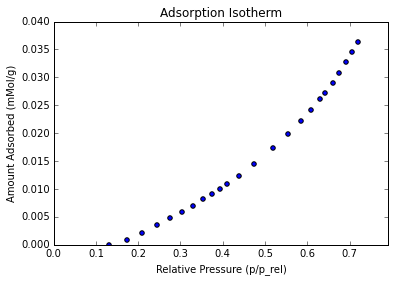

In [19]:
plt.scatter(p_rel, n,label='Amount adsorbed')
plt.title('Adsorption Isotherm')
plt.xlabel('Relative Pressure (p/p_rel)')
plt.ylabel('Amount Adsorbed (mMol/g)')
x_max = max(p_rel) + (0.1 * max(p_rel))
y_max = max(n) + (0.1 * max(n))
plt.ylim(0,y_max)
plt.xlim(0,x_max)

#  BET  equation plot and calculation

$$\frac{p}{n(p-p_{sat})}=\frac{C-1}{n_{m}C}\frac{p}{p_{sat}}+\frac{1}{n_{m}C}$$

In [20]:
# setting Y axis for BET plot
y_BET = p_reindex / (n * (p_sat - p_reindex))

In [21]:
# set up BET dataframe
BET_df = pd.concat([p_rel, y_BET], axis = 1)
BET_df.columns = ['p_rel', 'y_BET']

In [22]:
# BET equation is only valid between p_rel values of 0.05 to 0.35
BET_df = BET_df[(BET_df.p_rel >= 0.05) & (BET_df.p_rel <= 0.35)]

In [23]:
BET_df['sq_resid'] = np.nan
BET_df

,p_rel,y_BET,sq_resid
0,0.131579,inf,NaN
3,0.063639,-24.001328,NaN
4,0.097430,-62.608674,NaN
5,0.133732,-289.453672,NaN
6,0.172710,248.647780,NaN
7,0.209798,121.281138,NaN
8,0.245030,91.246937,NaN
9,0.275334,79.651729,NaN
10,0.303687,73.433052,NaN
11,0.328988,69.604294,NaN


In [24]:
# Function does linear regression and if threshold r_sq values isnt reached it removes point with largest square residual
# and repeats the linear regression without that point until r_sq value is reached

def regress(df):
    # Linear regression of BET plot within allowed p_rel range
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['p_rel'],df['y_BET'])
    
    r_sq = r_value ** 2
    
    
    if r_sq < 0.995:
        
        df['sq_resid'] = (df['y_BET'] - ((df['p_rel'] * slope) + intercept)) ** 2
        
        return regress(df.drop(df['sq_resid'].idxmax()))
    
    else:
        
        sse = ((df['y_BET'] - ((slope * df['p_rel']) + intercept)) ** 2).sum()
        n = len(df['p_rel'])
        var = np.sqrt((sse / (n - 2)))
        x_mean = df['p_rel'].mean()
        sx2 = ((df['p_rel'] - x_mean) **2).sum()
        intercept_err = var * np.sqrt((1/n) + (x_mean ** 2) / sx2)
        print df
        
        return slope,intercept,r_value,p_value,std_err,r_sq, intercept_err
        
        
  

In [25]:
slope,intercept,r_value,p_value,std_err,r_sq, intercept_err = regress(BET_df)

       p_rel       y_BET  sq_resid
0   0.131579         inf       NaN
3   0.063639  -24.001328       NaN
4   0.097430  -62.608674       NaN
5   0.133732 -289.453672       NaN
6   0.172710  248.647780       NaN
7   0.209798  121.281138       NaN
8   0.245030   91.246937       NaN
9   0.275334   79.651729       NaN
10  0.303687   73.433052       NaN
11  0.328988   69.604294       NaN


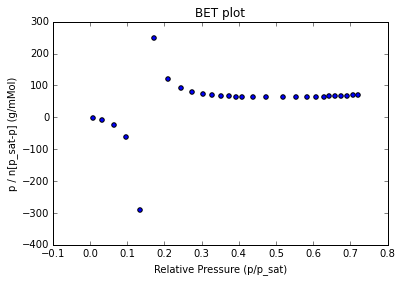

In [26]:
# BET plot
plt.scatter(p_rel,y_BET)
plt.plot(p_rel, (p_rel * slope) + intercept, c='r')
plt.title('BET plot')
plt.xlabel('Relative Pressure (p/p_sat)')
plt.ylabel('p / n[p_sat-p] (g/mMol)')


$$n_{m}=\frac{1}{slope+intercept}$$

In [27]:
# The monolayer capacity, n_m is found from slope and intercept of fitted line from BET plot

n_m = 1 / (slope + intercept) # mMol/g
err_slope_intercept = np.sqrt((std_err) ** 2 + (intercept_err) ** 2) # error in slope+intercept
n_m_err = n_m * (err_slope_intercept / (slope + intercept)) # error in n_m
n_m = n_m / 1000 # change units from mMol/g to Mol/g
n_m_err = n_m_err / 1000 # change units from mMol/g to Mol/g

#  Specific Surface Area, $\frac{m^{2}}{g}$

$$S_{BET}=n_{m}N_{a}a$$

In [28]:
a = 6.3E-19 # m^2 This is the cross-sectional surface area of a Octane molecule
Na = constants.Avogadro

In [29]:
ssa = n_m * Na * a
ssa_err = ssa * (n_m_err / n_m)

In [30]:
print 'The SSA is %.2f with error %.2f and R^2 of %.4f' % (ssa,ssa_err,r_sq)

The SSA is nan with error nan and R^2 of nan
